Load Fastai with all I need to work:

In [1]:
from fastai.vision import *
import glob
import os
import pandas as pd
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
from torchvision import transforms, utils
from fastai.vision import *

Create a class to serch the weight decays for each learning rate we want to survey:

In [3]:
@dataclass
class wd_finder:
    learn: Learner
    wd:Union[int,Callable] = None
    
    def __post_init__(self, **kwargs):
        self.wd_list = listify(self.wd)
        self.wd_recorder = []
        
        if self.wd is None:
            self.wd_list = [0,1e-1,1e-3,1e-5]
            
        for wd in self.wd_list:
            self.learn.lr_find(wd=self.wd,**kwargs)
            self.wd_recorder.append(self.learn.recorder)
            
    def plot_wd(self, skip_start:int=10, skip_end:int=5)->None:
        _, ax = plt.subplots(1,1)
        
        for k, i in enumerate(self.wd_recorder):
            losses = i.losses[skip_start:-skip_end] if skip_end > 0 else i.losses[skip_start:]
            lrs = i.lrs[skip_start:-skip_end] if skip_end > 0 else i.lrs[skip_start:]
            ax.plot(lrs, losses, label='WD={}'.format(self.wd_list[k]))
            ax.set_xlabel('Learning Rate')
            ax.set_ylabel('Loss')
            ax.legend()
            ax.set_xscale('log')

Set the Path where the datablock api will fetch our images for the multilabel classification:

In [4]:
path = Path('All images//')

Set the transformations we will apply in our training dataset:

In [8]:
tfms = get_transforms(rand_resize_crop(224), max_rotate=30, max_zoom=1.3, max_lighting=0.4, max_warp=0.,
                     p_affine=1., p_lighting=1.)

define the dataset using the datablock api, for the multilabel classification we are going to pass the image names and their respective targets using the from_csv method, where we have the label colum separated by '|' with the findings for each respective image.

In [9]:
np.random.seed(42)
data = ImageDataBunch.from_csv(path, label_delim='|', 
                               csv_labels='label list.csv', label_col=1, delimiter=',', valid_pct=0.2,
                              ds_tfms=tfms, bs=64, size=224, num_workers=3).normalize()

Check the classes:

In [10]:
data.classes

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [11]:
data.batch_size

64

We can also have a look at one batch of image from our train dataset:

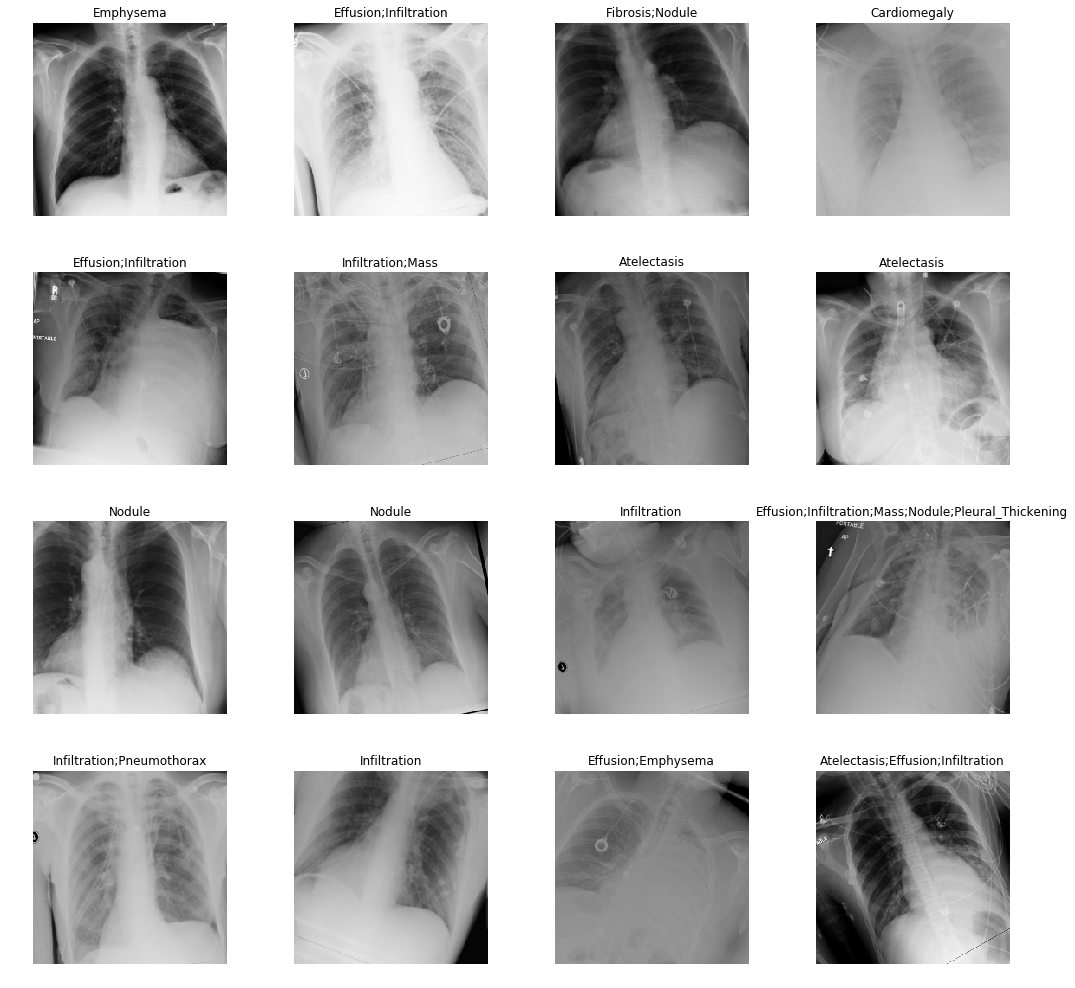

In [12]:
data.show_batch(rows=4, figsize=(15,14))

We can check the classes, their numbers, the number of entries in the train and validation dataset:

In [13]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Atelectasis',
  'Cardiomegaly',
  'Consolidation',
  'Edema',
  'Effusion',
  'Emphysema',
  'Fibrosis',
  'Hernia',
  'Infiltration',
  'Mass',
  'Nodule',
  'Pleural_Thickening',
  'Pneumonia',
  'Pneumothorax'],
 14,
 41408,
 10351)

In the multilabel class we have the problem of co-occurrences of classes, due to this we are going to use the diagonal values of the co-occurrence matrix for the disease. The diagonal values of the co-occurrence matrix will gives us the number of entries which has only one class associated.

To calculate the co-occurrence matrix we can use the CountVectorizer method from the sklearn.feature_extraction.text:

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

Loading the csv file with the image and labels we saved before:

In [ ]:
df = pd.read_csv('All images/label list.csv', sep=',')

In [15]:
cv = CountVectorizer(ngram_range=(1,1), stop_words='english')

In [16]:
X= cv.fit_transform(df['Diseases'])

In [17]:
import scipy.sparse as sp

Xc = (X.T *X)
g = sp.diags(1./Xc.diagonal())
Xc_norm = g*Xc

In [18]:
t = 0
for i in range(len(data.classes)):
    t += Xc[10,i]
print(t)

12065


In [19]:
for i in range(len(data.classes)):
    sum_it = 0
    for j in range(len(data.classes)):
        sum_it += Xc[i,j]
    print(i,sum_it)

0 23457
1 5606
2 10550
3 5126
4 28383
5 5216
6 3173
7 402
8 35780
9 11992
10 12065
11 7441
12 3338
13 10261


Calculating the positive weights for each class:

In [20]:
pos_weights = []
for i in range(len(data.classes)):
    sum_it = 0
    for j in range(len(data.classes)):
        sum_it += Xc[i,j]
    print('{}:'.format(data.classes[i]), (Xc.diagonal()[i])/(sum_it - Xc.diagonal()[i]))
    pos_weights.append((Xc.diagonal()[i])/(sum_it - Xc.diagonal()[i]))

Atelectasis: 0.9715078164397378
Cardiomegaly: 0.9809187279151943
Consolidation: 0.7933027366989631
Edema: 0.8157987956075098
Effusion: 0.883910792512943
Emphysema: 0.9318518518518518
Fibrosis: 1.1338264963012776
Hernia: 1.2971428571428572
Infiltration: 1.2522976205463932
Mass: 0.9310789049919485
Nodule: 1.1041158004883154
Pleural_Thickening: 0.8345660749506904
Pneumonia: 0.7503932878867331
Pneumothorax: 1.0691671708005646


If we want to test different architectures for the classifier layer we can simple create a new 'header' using the same sintax as in pytorch and in the cnn_learner we can pass the new 'header' to the parameter cnn_learner.

In [21]:
head_reg = nn.Sequential(Flatten(),
                        nn.Linear(50176,data.c)
                        )

to use the weights in our loss function we need to transform them into tensors and move to the GPU memory where the model will be loaded:

In [48]:
pos_class_weights = torch.FloatTensor(pos_weights).cuda()
loss_func = nn.BCEWithLogitsLoss(pos_weight=pos_class_weights)

We can include new metrics to be calculating during the training phase:

In [22]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2, beta=1)

Build the model we are going to use, we can use any archtecture avalaible for pytorch vision applications (ResNet, VGG, ...). In our case we are using the body from the densenet121, the head is automatically created by fastai https://docs.fast.ai/vision.learner.html#cnn_learner 

In [23]:
learner = cnn_learner(data, models.densenet121, pretrained=False, metrics=[acc_02, f_score])

/home/felipe/anaconda3/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


To save some GPU memory and speed up the training we are going to use mixed precision training. The to_fp16() module allows the forward and backward passes of your neural net to be done in fp16 (also known as half precision). This is particularly important if you have an NVIDIA GPU with tensor cores, since it can speed up your training by 200% or more.

In [51]:
learner.to_fp16();

In [52]:
learner.loss_func

BCEWithLogitsLoss()

Since we are going to training our model from beginning to end, we need to unfreeze all layers first, to do so we use the unfreeze() method. If one wants to use transfer learning the freeze_to(n) where n is the desirable up to layer one wants to freeze. 

In [54]:
learner.unfreeze()

using the class we defined before to find the weight decay use by our optimizer:

In [55]:
find_wd = wd_finder(learner)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


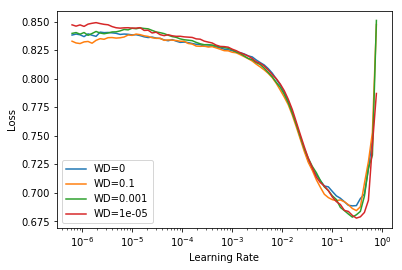

In [56]:
find_wd.plot_wd()

To scan the learning rate we can use the method lr_find with the weight decay we choosed.

In [57]:
learner.lr_find(wd=1e-5)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.29E-02


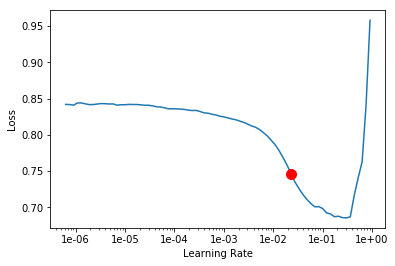

In [58]:
learner.recorder.plot(suggestion=True)

In [59]:
sug_lr = learner.recorder.min_grad_lr

Start the model training using the fit one cycle method and everything we gather so far (best learning rate, weight decay, etc)

In [60]:
learner.fit_one_cycle(30, slice(sug_lr/10,sug_lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.304173,0.295489,0.834178,0.371472,15:04
1,0.299928,0.295324,0.829389,0.373668,08:40
2,0.295063,0.290603,0.838449,0.385950,08:41
3,0.297778,0.294264,0.814959,0.380502,08:42
4,0.297291,0.318652,0.833432,0.378952,08:40
5,0.298242,0.293595,0.848393,0.388178,08:38
6,0.297289,0.303098,0.844660,0.383356,08:42
7,0.297744,0.321417,0.841582,0.389384,08:40
8,0.300067,0.296619,0.830037,0.377065,08:41
9,0.291642,0.289746,0.831356,0.401071,08:42


We can save our trained model to be further trained using transfer learning or use the model in the app we are going to set up in Heroku.

In [61]:
learner.save('Dense-121-stage-1-MP-RandomCropZomm-PW2')

In [24]:
learner.load('Dense-121-stage-1-MP-RandomCropZomm-PW2');

In [25]:
learner.export('Dense-121-stage-1-MP-RandomCropZomm-PW2')

To use our model we first load the saved model and freeze all layers with the exception of the last layer (classification layer).

In [ ]:
learner.freeze()

In [ ]:
learner.lr_find()

In [ ]:
find_wd = wd_finder(learner,wd=(1e-3,1e-5,1e-7))

In [ ]:
find_wd.plot_wd()

In [ ]:
learner.recorder.plot()

In [ ]:
learner.fit_one_cycle(15,slice(2e-7,1e-6))

In [ ]:
learner.save('Dense-121-stage-2-MP-RandomCropZomm-PW2')

In [ ]:
learner.load('Dense-121-stage-2-MP-RandomCropZomm-PW2');

In [ ]:
learner.recorder.plot_lr(show_moms=True)

In [ ]:
learner.freeze()

In [ ]:
find_wd = wd_finder(learner,wd=(1e-3,1e-5,1e-7))

In [ ]:
find_wd.plot_wd()

In [ ]:
learner.lr_find(start_lr=1e-5,end_lr=2e-3)

In [ ]:
learner.recorder.plot()

In [ ]:
learner.fit_one_cycle(15,slice(2.2e-5,1.5e-4))

In [ ]:
learner.save('Dense-121-stage-3-MP-RandomCropZomm-PW2')

In [ ]:
learner.load('Dense-121-stage-3-MP-RandomCropZomm-PW2');

In [ ]:
learner.freeze()

In [ ]:
find_wd = wd_finder(learner,wd=(1e-3,1e-5,1e-7))

In [ ]:
find_wd.plot_wd()

In [ ]:
learner.recorder.plot_losses()

In [ ]:
learner.recorder.plot_metrics()

In [ ]:
learner.recorder.plot_lr(show_moms=True)